In [41]:
import torch
import torch.nn as nn
from torch.functional import F
import torchvision
from torch.utils.data import DataLoader
import torchvision.transforms.v2 as tvt
import torch.optim as optim
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import clear_output

In [30]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
dataset = torchvision.datasets.MNIST("./data", download=True, transform=tvt.Compose([tvt.ToTensor()]))

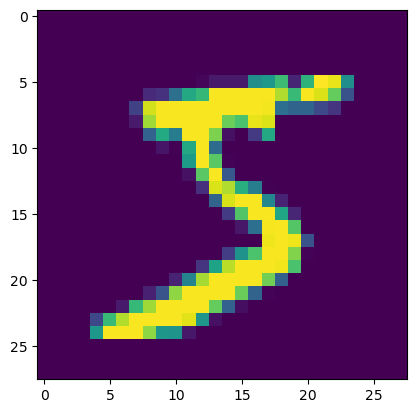

In [8]:
plt.imshow(dataset[0][0].permute(1, 2, 0))

In [38]:
class MyCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(3)
        )
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(64)
        )

        self.conv_block3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(128)
        )

        self.dropout1 = nn.Dropout(0.3)

        self.fc = nn.Sequential(
            nn.Linear(128*5*5, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )


    def forward(self, x):
        x = self.conv_block1(x)
        x = self.dropout1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        
        x = x.flatten(1)

        return self.fc(x)

In [39]:
model = MyCNN()
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=3e-4)

In [35]:
train_dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [36]:
def train_model(model, train_data_loader, criterion, optimizer, epochs=10):
    model.train()
    loss_hist = []
    for epoch in range(epochs):
        loss_sum, batch_count = 0, 0
        for batch in tqdm(train_data_loader):
            x, y = batch[0].to(device), batch[1].to(device)
            optimizer.zero_grad()
            y_predicted = model(x)
            loss = criterion(y_predicted, y)
            loss.backward()
            optimizer.step()
            loss_sum += loss.item()
            batch_count += 1
        loss_hist.append(loss_sum / batch_count)
        clear_output()
        fig = plt.figure(figsize=(15, 7))
        plt.plot(np.arange(1, epoch + 2), loss_hist, label='train')
        plt.xlabel('epoch')
        plt.ylabel('loss')
        fig.legend()
        plt.show()

        print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss_hist[-1]}")
        
    model.eval()
    torch.save(model.state_dict(), f'symbol_model_ep{epochs}.pt')

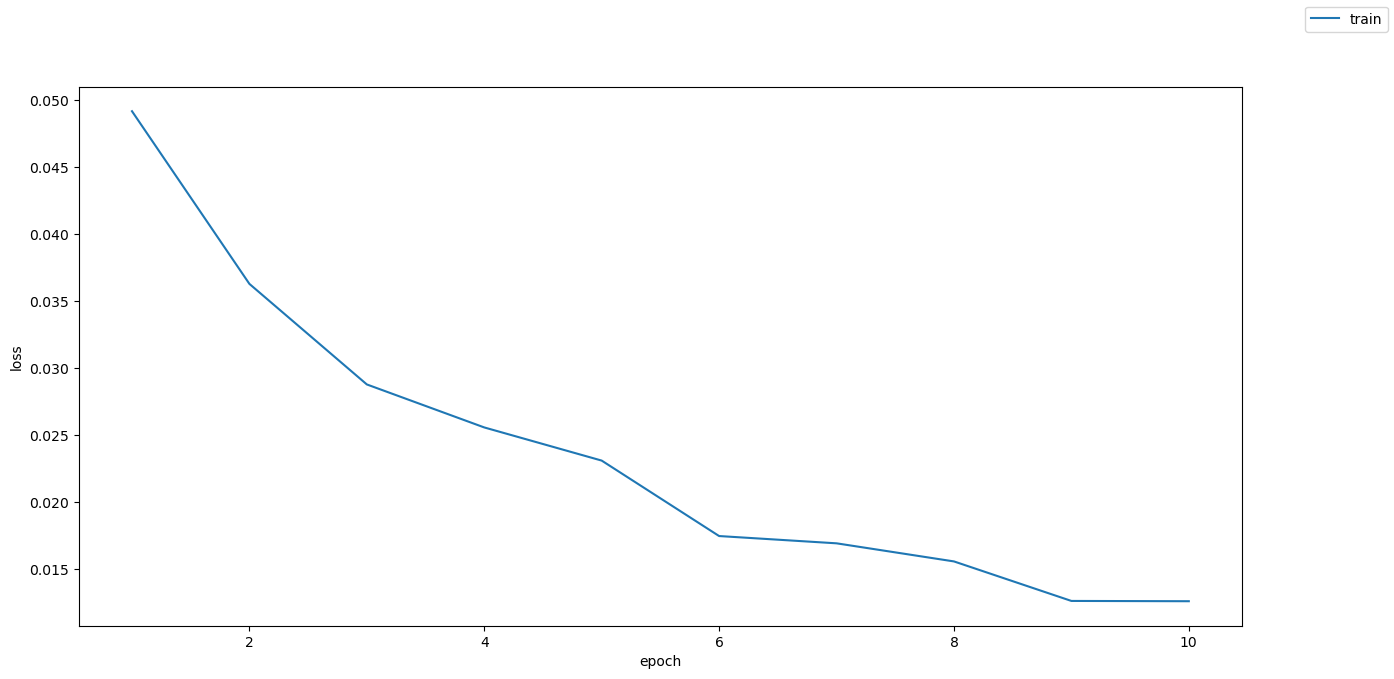

Epoch 10/10, Loss: 0.012582692120298816


In [42]:
train_model(model, train_dataloader, criterion, optimizer, 10)

In [44]:
model.eval()

MyCNN(
  (conv_block1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_block3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (dropout1): Dropout(p=0.3, inplace=False)
  (fc): Sequential(
    (0): Linear(in_features=3200, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=10, bias=True)
  )
)

In [56]:
img = dataset[123][0].unsqueeze(0).cuda()
pred = model(img)


In [57]:
pred = pred.detach().cpu()

In [58]:
F.softmax(pred).argmax()

C:\Users\skygo\AppData\Local\Temp\ipykernel_15292\1622784092.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  F.softmax(pred).argmax()


tensor(7)

In [59]:
dataset[123][1]

7